In [74]:
import tensorflow as tf
from model import HyperModel
import json
from vocab import Vocab
import pickle
import os
import bunch
import numpy as np

In [75]:
from matplotlib import pyplot

In [76]:
expdir = 'exps/scotuss15'

In [77]:
tf.reset_default_graph()

In [78]:
param_filename = os.path.join(expdir, 'params.json')
with open(param_filename, 'r') as f:
    params = bunch.Bunch(json.load(f))

In [79]:
vocab = Vocab.Load(os.path.join(expdir, 'word_vocab.pickle'))
with open(os.path.join(expdir, 'context_vocab.pickle'), 'rb') as f:
    context_vocabs = pickle.load(f)

In [80]:
unigram_probs = vocab.GetUnigramProbs()
model = HyperModel(
  params, unigram_probs,
  [len(context_vocabs[v]) for v in params.context_vars],
  use_nce_loss=False)

In [81]:
saver = tf.train.Saver(tf.all_variables())

session = tf.Session()
saver.restore(session, os.path.join(expdir, 'model.bin'))

In [42]:
a = model.base_bias.eval(session=session)
a.shape

(18131,)

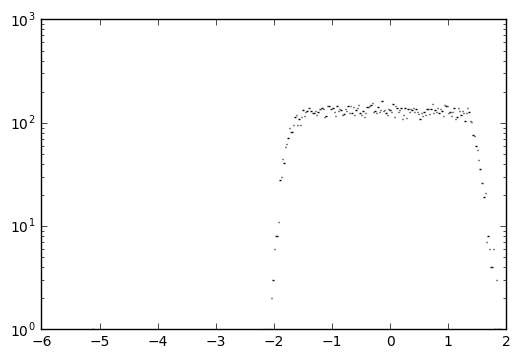

In [43]:
pyplot.hist(a, bins=300)
pyplot.semilogy()
pyplot.show()

In [11]:
(np.abs(a) < 0.001).sum() / float(len(a))

0.00060211769198008607

In [12]:
for t in tf.trainable_variables():
    print t.name

c_embed_subreddit:0
word_embeddings:0
base_bias:0
hash_table:0
hyper_lstm_cell/bias:0
hyper_lstm_cell/adaptation_weights:0
hyper_lstm_cell/mikolov_biases:0
linear_proj:0
RNN/hyper_lstm_cell/weights:0


In [13]:
sub_mul = tf.matmul(tf.trainable_variables()[0], tf.trainable_variables()[5])

In [14]:
z = sub_mul.eval(session=session)
q = tf.trainable_variables()[0].eval(session=session)

(5693, 720)


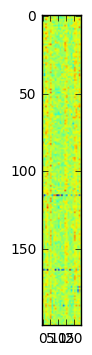

In [15]:
print z.shape
pyplot.imshow(q[:200, :], interpolation=None)
pyplot.show()

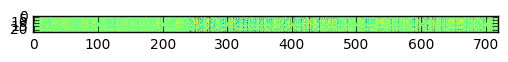

In [16]:
a = tf.trainable_variables()[5].eval(session=session)
b = np.sign(a) * np.log(1.0 + np.abs(a))
pyplot.imshow(a, interpolation=None)
pyplot.show()


In [17]:
z[:10, :10]

array([[-0.29994318,  0.20301825, -0.32066584, -0.12963487,  0.2583738 ,
         0.16078921, -0.21677989,  0.38411143,  0.58373445, -0.32359403],
       [-0.44373524,  0.26919949, -0.34366092, -0.1040761 ,  0.31389725,
         0.18400814, -0.24305445,  0.34417808,  0.49055696, -0.36334196],
       [-0.47504637,  0.29304823, -0.39564914, -0.01780747,  0.29427713,
         0.21435575, -0.2629886 ,  0.46048173,  0.65947872, -0.45846727],
       [-0.39081097,  0.224538  , -0.36577308,  0.02991124,  0.34312043,
         0.21867955, -0.28692222,  0.38516355,  0.6067    , -0.5021233 ],
       [-0.47295204,  0.21238853, -0.3498528 ,  0.0252618 ,  0.26771808,
         0.21335483, -0.2407784 ,  0.36939597,  0.60197008, -0.4360441 ],
       [-0.41239133,  0.20654504, -0.32819879,  0.23001328,  0.29798132,
         0.17793754, -0.23477747,  0.3636927 ,  0.47681111, -0.38209462],
       [-0.39733049,  0.21982457, -0.30802688,  0.02380122,  0.27608022,
         0.17661932, -0.23819484,  0.31888288

In [18]:
import numpy as np
import collections

In [66]:
cvar = 'case'
_sub_hash, _sub_bloom, _sub_h = model.HashGetter(model.all_ids, {cvar: model.context_placeholders[cvar]},
                                             debug=True)

In [67]:
new_table = collections.defaultdict(list)
subreddit_vocab = context_vocabs[cvar]
for subreddit_id in range(len(subreddit_vocab)):
    if subreddit_id % 50 == 0:
        print subreddit_id
    hash_vals, hash_idx, bloom = session.run([_sub_hash, _sub_h, _sub_bloom], 
                                             {model.context_placeholders[cvar]: np.array([subreddit_id])})
    for idx in np.where(bloom)[0]:
        new_table[hash_idx[idx]].append((subreddit_vocab[subreddit_id], vocab[idx], hash_vals[idx]))

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750


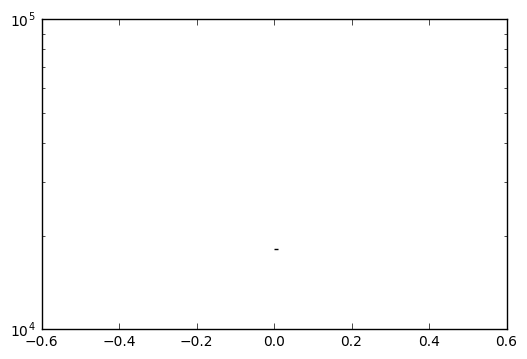

In [70]:
pyplot.hist(hash_vals, bins=100)
pyplot.semilogy()
pyplot.show()

In [71]:
all_items = []
for item_list_id in new_table:
    item_list = new_table[item_list_id]
    for item in item_list:
        all_items.append({'subreddit': item[0], 'word': item[1], 'val': item[2], 'idx': item_list_id})

In [72]:
import pandas
d = pandas.DataFrame(all_items)

In [73]:
d.sort_values('val', inplace=True, ascending=False)
d.head(300)

,idx,subreddit,val,word
27,2897461,2007_07_371,2.142369,disallowing
17,707615,2007_06_1463,1.795969,abettors
69,839165,1990_106_orig,0.917580,1939
53,2176735,1992_91_1600,0.842067,businessman
4,1511940,1997_97_1374,0.839368,affiliates
47,1591636,1997_96_7171,0.825370,wink
58,2141032,1990_88_1847,0.806619,#
56,2842724,2001_00_1853,0.732838,evaporate
20,858371,2010_09_115,0.724932,alternative
40,2125257,1992_92_486,0.626186,discretionary


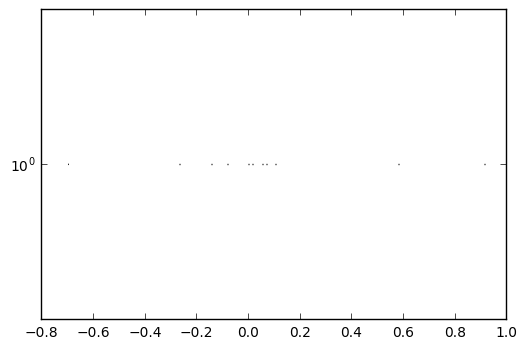

In [52]:
pyplot.hist(d.val, bins=500)
pyplot.semilogy()
pyplot.show()

In [53]:
d

,idx,subreddit,val,word
12,839165,advocate,0.917580,1939
8,2682357,advocate,0.581860,articulation
4,2364620,advocate,0.328463,1b1.10
6,1634672,advocate,0.105402,adhered
7,1777682,advocate,0.070342,arbitrators
11,1321775,advocate,0.056474,acute
1,1544864,advocate,0.019720,academic
5,274109,advocate,0.015546,500
10,2638680,advocate,0.002655,administering
9,446295,advocate,-0.077392,abrogating


In [ ]:
pyplot.hist(d[d.subreddit == 'exmormon'].val, bins=100)
pyplot.show()

In [82]:
dfperson = pandas.read_csv('/s0/ajaech/scotuss15_person_hash.csv')

In [83]:
dfrole = pandas.read_csv('/s0/ajaech/scotuss15_role_hash.csv')

In [84]:
dfcase = pandas.read_csv('/s0/ajaech/scotus_hash_case.csv')

In [98]:
len(dfperson), len(dfrole), len(dfcase)

(1604316, 57290, 1988057)

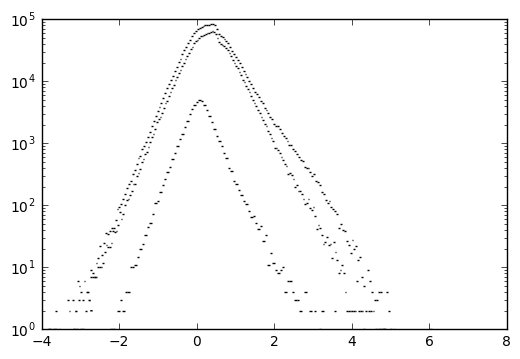

In [99]:
pyplot.hist(dfperson.hash, bins=200)
pyplot.hist(dfrole.hash, bins=100)
pyplot.hist(dfcase.hash, bins=200)
pyplot.semilogy()
pyplot.show()

In [100]:
from scipy.stats import gaussian_kde

density_person = gaussian_kde(dfperson.hash)
density_role = gaussian_kde(dfrole.hash)
density_case = gaussian_kde(dfcase.hash)



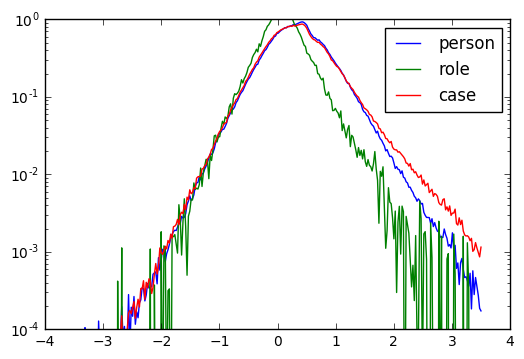

In [109]:
xs = np.linspace(-3.5, 3.5, 300)
k = 0.01
density_person.covariance_factor = lambda : k
density_person._compute_covariance()
density_role.covariance_factor = lambda : k
density_role._compute_covariance()
density_case.covariance_factor = lambda : k
density_case._compute_covariance()


pyplot.plot(xs, density_person(xs))
pyplot.plot(xs, density_role(xs))
pyplot.plot(xs, density_case(xs))
pyplot.legend(['person', 'role', 'case'])
pyplot.semilogy()
pyplot.ylim([0.0001, 1.0])
pyplot.show()